<a href="https://colab.research.google.com/github/David-Carballo/2023w-project-pose/blob/main/pose_extractor_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup Kaggle
Load kaggle.json file with your Kaggle API Token in Settings>Account>Create New API Token

### Install the Kaggle library

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# make a directory named ".kaggle"
! mkdir ~/.kaggle
# copy the "kaggle.json" file into this new directory
! cp kaggle.json ~/.kaggle/
# allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


### Upload Kaggle Dataset

In [5]:
#Load kaggle.json file with your Kaggle API Token in Settings>Account>Create New API Token
! kaggle datasets download tr1gg3rtrash/yoga-posture-dataset
#unzip dataset
! mkdir data
! unzip yoga-posture-dataset.zip -d data/

100% 446M/447M [00:16<00:00, 32.3MB/s]
100% 447M/447M [00:16<00:00, 27.9MB/s]
mkdir: cannot create directory ‘data’: File exists
Archive:  yoga-posture-dataset.zip
  inflating: data/Adho Mukha Svanasana/File1.png  
  inflating: data/Adho Mukha Svanasana/File10.png  
  inflating: data/Adho Mukha Svanasana/File11.png  
  inflating: data/Adho Mukha Svanasana/File12.png  
  inflating: data/Adho Mukha Svanasana/File13.png  
  inflating: data/Adho Mukha Svanasana/File14.png  
  inflating: data/Adho Mukha Svanasana/File15.png  
  inflating: data/Adho Mukha Svanasana/File16.png  
  inflating: data/Adho Mukha Svanasana/File17.png  
  inflating: data/Adho Mukha Svanasana/File18.png  
  inflating: data/Adho Mukha Svanasana/File19.png  
  inflating: data/Adho Mukha Svanasana/File2.png  
  inflating: data/Adho Mukha Svanasana/File20.png  
  inflating: data/Adho Mukha Svanasana/File21.png  
  inflating: data/Adho Mukha Svanasana/File22.png  
  inflating: data/Adho Mukha Svanasana/File23.png  
  infl

#1 Dataset

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from PIL import Image
import os
#from customDataset import YogaPoses

device = 'cuda'

In [11]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':10,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-4,
    'log_interval':100,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
class YogaDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.images = []
        self.labels = []

        for subdir in os.listdir(data_dir):
            subdir_path = os.path.join(data_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in os.listdir(subdir_path):
                    file_path = os.path.join(subdir_path, file)
                    if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png'):
                        self.images.append(file_path)
                        self.labels.append(subdir)

    def __getitem__(self, index):
        img_path = self.images[index]
        img = Image.open(img_path).convert('RGB') #CHECK
        tensor_img = transforms.ToTensor()(img)
        tensor_img = self.image_transform(tensor_img)
        label = self.labels[index]
        return tensor_img, label
    
    def image_transform(self, tensor):
        resize = transforms.Resize(224)
        #Check if image size ratio is 1:1
        if tensor.shape[1] != tensor.shape[2]:
            #Calculate difference between X and Y axis
            diff = tensor.shape[1] - tensor.shape[2]
        #Check what dimension needs to be padded either the X (dimension 1 of the tensor, right), or the Y (dimension 3, bottom)
        if diff > 0:     
            tensor = F.pad(input=tensor, pad=(0, abs(diff), 0, 0), mode='constant', value=0) #pad(left, right, top, bottom)
        else:
            tensor = F.pad(input=tensor, pad=(0, 0, 0, abs(diff)), mode='constant', value=0)
        tensor = resize(tensor)
        tensor = tensor.reshape(3, 224, 224)
        return tensor
    
    def __len__(self):
        return len(self.images)

In [25]:
data_dir = 'data'

yoga_dataset = YogaDataset(data_dir)
n_train = int(0.8 * len(yoga_dataset))

train_set, test_set = torch.utils.data.random_split(yoga_dataset, [n_train, len(yoga_dataset) - n_train])

In [26]:
train_loader = DataLoader(dataset=train_set, batch_size=hparams['batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=hparams['batch_size'], shuffle=False)

In [27]:
img, label = train_set[0]
print('Img shape: ', img.shape)
print('Label: ', label)

print(len(yoga_dataset))

Img shape:  torch.Size([3, 224, 224])
Label:  Utkatasana
2756


#2. Pose extraction
First of all, we will download OpenPose Model from Github.

In [ ]:
!pip install git+https://github.com/prasunroy/openpose-pytorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/prasunroy/openpose-pytorch.git to /tmp/pip-req-build-uc75x1ty
  Running command git clone --filter=blob:none --quiet https://github.com/prasunroy/openpose-pytorch.git /tmp/pip-req-build-uc75x1ty
  Resolved https://github.com/prasunroy/openpose-pytorch.git to commit 8955ef1d220d5dc43dd5e573a49e323393ae5446
  Preparing metadata (setup.py) ... done
  Created wheel for openpose-pytorch: filename=openpose_pytorch-0.1.0-py3-none-any.whl size=10272 sha256=ec59fa1589176d336addfdcc36a71b83baaa30f6f8bc7679e15ad5c71454faca
  Stored in directory: /tmp/pip-ephem-wheel-cache-k192mpqx/wheels/64/1f/0f/2a675daf6025f595170f0f288fd3b7e04e7502528ac9860516
Successfully built openpose-pytorch


In [ ]:
import sys
import os
import cv2
from openpose.body.estimator import BodyPoseEstimator
from openpose.utils import draw_body_connections, draw_keypoints
from google.colab.patches import cv2_imshow 
import math
import copy

Poses 18 keypoints (Yellow=BodyHead, Purple=ArmLegLeft, Blue=ArmLegRight) : Origin (UP-RIGHT)
<img src='https://drive.google.com/uc?id=1qGRPPKY3ar-yQAQ05uHg2Lt4oeDKvPQn
'>

0. head
1. neck
2. right_shoulder
3. right_elbow
4. right_hand

5. left_shoulder
6. left_elbow
7. left_hand

8. right_hip
9. right_knee
10. right_foot

11. left_hip
12. left_knee
13. left_foot

14. right_eye
15. left_eye
16. right_ear
17. left_ear

##2.1 Pose extraction example
We going to provide an example about how extract a pose from image with OpenPose Model

[[[511 108   1]
  [508 227   1]
  [411 224   1]
  [288 309   1]
  [303 198   1]
  [603 231   1]
  [669 367   1]
  [620 483   1]
  [450 516   1]
  [435 734   1]
  [439 935   1]
  [574 516   1]
  [566 738   1]
  [562 949   1]
  [491  89   1]
  [527  90   1]
  [459 106   1]
  [555 108   1]]]


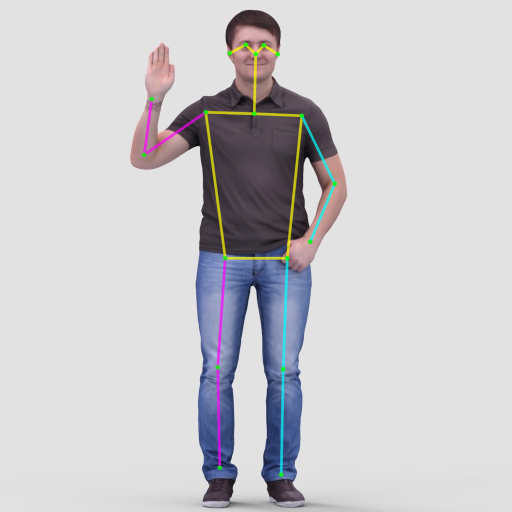

In [ ]:
estimator = BodyPoseEstimator(pretrained=True)

path_image = '/content/human.jpg'

img = cv2.imread(path_image)
keypoints = estimator(img)

print(keypoints)


skeleton = draw_body_connections(img, keypoints, thickness=4, alpha=0.7)
skeleton = draw_keypoints(skeleton, keypoints, radius=4, alpha=0.8)

cv2_imshow(cv2.resize(skeleton, (512, 512)))

### Get Angles from previous Keypoint
Each connection consists of two points A and B. To calculate the angle between these two, the first keypoint is chosen as a reference point, our origin of coordinates, then we obtain the angle of the second Keypoint with respect to that reference point.

In [ ]:
# Get angles from body keipoints(clockwise). Compute angle respect previous keypoint
def get_angles_previous(keypoints):
    output = []
    body_conn = [(0, 1), (1, 2), (1, 5), (2, 8), (5, 11), (8, 11)]
    left_conn = [(5, 6), (6, 7), (11, 12), (12, 13)]
    right_conn = [(2, 3), (3, 4), (8, 9), (9, 10)]
    head_conn = [(0, 14), (0, 15), (14, 16), (15, 17)]
    for kp in keypoints:
        for a,b in body_conn:
            angle = math.atan2(kp[b][1]-kp[a][1], kp[b][0]-kp[a][0] ) * (180/math.pi)
            print('{} y {} forman un angulo de {}'.format(a,b,angle))
            output.append(angle)
        for a,b in left_conn:
            angle = math.atan2(kp[b][1]-kp[a][1], kp[b][0]-kp[a][0] ) * (180/math.pi)
            print('{} y {} forman un angulo de {}'.format(a,b,angle))
            output.append(angle)
        for a,b in right_conn:
            angle = math.atan2(kp[b][1]-kp[a][1], kp[b][0]-kp[a][0] ) * (180/math.pi)
            print('{} y {} forman un angulo de {}'.format(a,b,angle))
            output.append(angle)
        for a,b in head_conn:
            angle = math.atan2(kp[b][1]-kp[a][1], kp[b][0]-kp[a][0] ) * (180/math.pi)
            print('{} y {} forman un angulo de {}'.format(a,b,angle))
            output.append(angle)
    return output

out =  get_angles_previous(keypoints)
print(out)

### Get Angles from reference Vector
First of all, create a vector between neck keypoint and hip keypoint. To obtain hip keypoint, calculate the center point between both hip keypoints.
Then compute the angle between the reference vector and the vector composed between points A and B of each connection. 

508 227
512.0 516.0


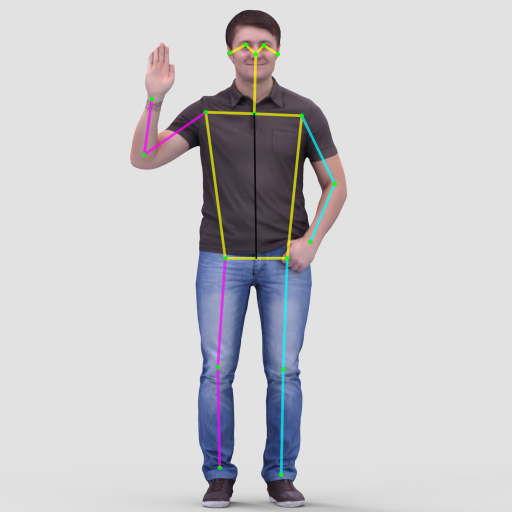

El vector entre 0 y 1 forman un angulo de 2.24
El vector entre 1 y 2 forman un angulo de 92.56
El vector entre 1 y 5 forman un angulo de 86.80
El vector entre 2 y 8 forman un angulo de 6.81
El vector entre 5 y 11 forman un angulo de 6.60
El vector entre 8 y 11 forman un angulo de 89.21
El vector entre 5 y 6 forman un angulo de 25.09
El vector entre 6 y 7 forman un angulo de 23.69
El vector entre 11 y 12 forman un angulo de 2.86
El vector entre 12 y 13 forman un angulo de 1.88
El vector entre 2 y 3 forman un angulo de 56.15
El vector entre 3 y 4 forman un angulo de 171.51
El vector entre 8 y 9 forman un angulo de 4.73
El vector entre 9 y 10 forman un angulo de 0.35
El vector entre 0 y 14 forman un angulo de 134.32º
El vector entre 0 y 15 forman un angulo de 137.57º
El vector entre 14 y 16 forman un angulo de 62.81º
El vector entre 15 y 17 forman un angulo de 56.47º
[2.2370960671719797, 92.56444027626995, 86.79599971715291, 6.814525182860716, 6.603069963955133, 89.20702946376414, 25.0940

In [ ]:
# Get x,y from neck keypoint(1)
x0 = keypoints[0][1][0]
y0 = keypoints[0][1][1]
print(x0,y0)
# Get x,y from hips keypoints(8,11)
x1 = (keypoints[0][11][0] + keypoints[0][8][0])/2
y1 = (keypoints[0][11][1] + keypoints[0][8][1])/2
print(x1,y1)

# Get vector reference from previous points
vec0_x = x1 - x0
vec0_y = y1 - y0
mag0 = math.sqrt(vec0_x**2 + vec0_y**2)

skeleton_ref = copy.deepcopy(skeleton)
cv2.line(skeleton_ref, (int(x0), int(y0)), (int(x1), int(y1)), (10, 10, 10), 2, cv2.LINE_AA)
cv2_imshow(cv2.resize(skeleton_ref, (512, 512)))
# Get vector from each body part
def get_angles_vector(keypoints):
    output = []
    # Connections between each keypoint
    body_conn = [(0, 1), (1, 2), (1, 5), (2, 8), (5, 11), (8, 11)]
    left_conn = [(5, 6), (6, 7), (11, 12), (12, 13)]
    right_conn = [(2, 3), (3, 4), (8, 9), (9, 10)]
    head_conn = [(0, 14), (0, 15), (14, 16), (15, 17)]
    for kp in keypoints:
        # Body connections
        for a,b in body_conn:
            # a,b compose vector
            vec_x = kp[b][0] - kp[a][0] 
            vec_y = kp[b][1] - kp[a][1] 
            # Dot product
            dot_product = vec0_x * vec_x + vec0_y * vec_y
            # Magnitude of vector
            mag = math.sqrt(vec_x**2 + vec_y**2)
            # Calculate angle cos-1 [ (a · b) / (|a| |b|) ]
            angle_rad = math.acos(dot_product / (mag0 * mag))
            angle_deg = math.degrees(angle_rad)
            output.append(angle_deg)
            #angle = math.atan2(kp[b][1]-kp[a][1], kp[b][0]-kp[a][0] ) * (180/math.pi)
            print('El vector entre {} y {} forman un angulo de {:.2f}'.format(a,b,angle_deg))

        # Left arm/leg connections
        for a,b in left_conn:
            # a,b compose vector
            vec_x = kp[b][0] - kp[a][0] 
            vec_y = kp[b][1] - kp[a][1] 
            # Dot product
            dot_product = vec0_x * vec_x + vec0_y * vec_y
            # Magnitude of vector
            mag = math.sqrt(vec_x**2 + vec_y**2)
            # Calculate angle cos-1 [ (a · b) / (|a| |b|) ]
            angle_rad = math.acos(dot_product / (mag0 * mag))
            angle_deg = math.degrees(angle_rad)
            output.append(angle_deg)
            #angle = math.atan2(kp[b][1]-kp[a][1], kp[b][0]-kp[a][0] ) * (180/math.pi)
            print('El vector entre {} y {} forman un angulo de {:.2f}'.format(a,b,angle_deg))

        # Right arm/leg connections
        for a,b in right_conn:
            # a,b compose vector
            vec_x = kp[b][0] - kp[a][0] 
            vec_y = kp[b][1] - kp[a][1] 
            # Dot product
            dot_product = vec0_x * vec_x + vec0_y * vec_y
            # Magnitude of vector
            mag = math.sqrt(vec_x**2 + vec_y**2)
            # Calculate angle cos-1 [ (a · b) / (|a| |b|) ]
            angle_rad = math.acos(dot_product / (mag0 * mag))
            angle_deg = math.degrees(angle_rad)
            output.append(angle_deg)
            #angle = math.atan2(kp[b][1]-kp[a][1], kp[b][0]-kp[a][0] ) * (180/math.pi)
            print('El vector entre {} y {} forman un angulo de {:.2f}'.format(a,b,angle_deg))

        # Head connections
        for a,b in head_conn:
            # a,b compose vector
            vec_x = kp[b][0] - kp[a][0] 
            vec_y = kp[b][1] - kp[a][1] 
            # Dot product
            dot_product = vec0_x * vec_x + vec0_y * vec_y
            # Magnitude of vector
            mag = math.sqrt(vec_x**2 + vec_y**2)
            # Calculate angle cos-1 [ (a · b) / (|a| |b|) ]
            angle_rad = math.acos(dot_product / (mag0 * mag))
            angle_deg = math.degrees(angle_rad)
            output.append(angle_deg)
            #angle = math.atan2(kp[b][1]-kp[a][1], kp[b][0]-kp[a][0] ) * (180/math.pi)
            print('El vector entre {} y {} forman un angulo de {:.2f}º'.format(a,b,angle_deg))
    return output

out =  get_angles_vector(keypoints)
print(out)    



##2.2 Extract Poses from Dataset

In [ ]:
estimator = BodyPoseEstimator(pretrained=True)

dataset_dir = '/content/dataset'
i_file = 1

# recorre cada clase
for yoga_class in os.listdir(dataset_dir):
    yoga_class_dir = os.path.join(dataset_dir, yoga_class)
    # recorre cada imagen de la clase
    for filename in os.listdir(yoga_class_dir):
        file_path = os.path.join(yoga_class_dir, filename)
        # lee la imagen
        print("Reading " + file_path)
        img = cv2.imread(file_path)
        # dibuja pose con keypoints
        keypoints = estimator(img)
        # imagen con pose
        skeleton = draw_body_connections(img, keypoints, thickness=4, alpha=0.7)
        skeleton = draw_keypoints(skeleton, keypoints, radius=5, alpha=0.8)
        # black con pose
        skeleton_black = draw_body_connections(img*0, keypoints, thickness=4, alpha=0.7)
        skeleton_black = draw_keypoints(skeleton_black, keypoints, radius=5, alpha=0.8)
        # cv2_imshow(image_dst)
        # guarda la imagen modificada
        data_path = '/content/data'
        class_path = os.path.join(data_path, yoga_class)

        imgpose_filename = os.path.splitext(filename)[0] + "_skeleton.jpg"
        imgpose_path = os.path.join(class_path, imgpose_filename)
        blackpose_filename = os.path.splitext(filename)[0] + "_skeleton_black.jpg"
        blackpose_path = os.path.join(class_path, blackpose_filename)

        cv2.imwrite(imgpose_path, skeleton)
        cv2.imwrite(blackpose_path, skeleton_black)
        print("Success saved: " + str(round(i_file/2792*100,2)) + '%')
        i_file += 1